In [2]:
from datetime import datetime
import pandas as pd
from glmtools.io.glm import GLMDataset
from glmtools.io.imagery import open_glm_time_series, aggregate
import os
import xarray as xr
from dateutil import parser
import numpy as np
import netCDF4 as nc
from  matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap


KeyboardInterrupt: 

In [ ]:
# constants
track_file = "./Data/Dorian/ATL_19_5_Dorian_Cubic_Spline_Trackfile.csv"
sample_glm_file = "./Data/GLM/2019/241/00/OR_GLM-L2-LCFA_G17_s20192410000000_e20192410000200_c20192410000227.nc"

In [ ]:
sample_data = GLMDataset(sample_glm_file).dataset

In [ ]:
sample_data

<xarray.Dataset>
Dimensions:                                 (number_of_events: 7592, number_of_field_of_view_bounds: 2, number_of_flashes: 336, number_of_groups: 3875, number_of_time_bounds: 2, number_of_wavelength_bounds: 2)
Coordinates: (12/21)
    event_id                                (number_of_events) uint32 6516915...
    event_time_offset                       (number_of_events) datetime64[ns] ...
    event_lat                               (number_of_events) float32 18.4 ....
    event_lon                               (number_of_events) float32 -96.69...
    event_parent_group_id                   (number_of_events) uint32 2826222...
    group_id                                (number_of_groups) uint32 2826222...
    ...                                      ...
    product_time                            datetime64[ns] 2019-08-29
    lightning_wavelength                    float32 ...
    group_time_threshold                    float32 ...
    flash_time_threshold                    float32 ...
    lat_field_of_view                       float32 ...
    lon_field_of_view                       float32 -137.0
Dimensions without coordinates: number_of_events, number_of_field_of_view_bounds, number_of_flashes, number_of_groups, number_of_time_bounds, number_of_wavelength_bounds
Data variables: (12/37)
    event_energy                            (number_of_events) float32 4.578e...
    group_frame_time_offset                 (number_of_groups) datetime64[ns] ...
    group_area                              (number_of_groups) float32 79.2 ....
    group_energy                            (number_of_groups) float32 4.578e...
    group_quality_flag                      (number_of_groups) float32 ...
    flash_frame_time_offset_of_first_event  (number_of_flashes) datetime64[ns] ...
    ...                                      ...
    event_x                                 (number_of_events) float32 0.104 ...
    event_y                                 (number_of_events) float32 0.0533...
    group_x                                 (number_of_groups) float32 0.104 ...
    group_y                                 (number_of_groups) float32 0.0533...
    flash_x                                 (number_of_flashes) float32 0.104...
    flash_y                                 (number_of_flashes) float32 0.053...
Attributes: (12/29)
    production_site:           WCDAS
    featureType:               point
    dataset_name:              OR_GLM-L2-LCFA_G17_s20192410000000_e2019241000...
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    institution:               DOC/NOAA/NESDIS> U.S. Department of Commerce, ...
    ...                        ...
    time_coverage_start:       2019-08-29T00:00:00.0Z
    time_coverage_end:         2019-08-29T00:00:20.0Z
    production_data_source:    Realtime
    production_environment:    OE
    LUT_Filenames:             GLM_CALINR_AllFilters(FM2W_CDRL79RevD_PR_08_01...
    id:                        70aff365-4e72-4d15-8c61-c19c47104eb2

In [ ]:
df = pd.read_csv(track_file)
df

,Unnamed: 0,Date,Long,Lat
0,0,2019-08-22 12:00:00,-35.900000,9.500000
1,1,2019-08-22 12:10:00,-35.934344,9.500114
2,2,2019-08-22 12:20:00,-35.968688,9.500228
3,3,2019-08-22 12:30:00,-36.003033,9.500341
4,4,2019-08-22 12:40:00,-36.037377,9.500453
...,...,...,...,...
2516,2516,2019-09-08 23:20:00,-54.968694,51.565349
2517,2517,2019-09-08 23:30:00,-54.934958,51.572286
2518,2518,2019-09-08 23:40:00,-54.901219,51.579219
2519,2519,2019-09-08 23:50:00,-54.867480,51.586148


In [ ]:
# from a single netcdf file return [date, groups_lat, groups_lon]
def reduce_file(data_file):
    data = GLMDataset(data_file).dataset
    # time data in format "YYYY-MM-DD HH:MM:SS"
    time_str = data.time_coverage_start[:-3].replace('T', ' ')
    
    # extract data about groups
    groups = data[['group_energy','group_area']]
    groups = groups.drop(['group_parent_flash_id','lightning_wavelength','product_time','group_time_threshold','flash_time_threshold','lat_field_of_view','lon_field_of_view'])
    
    # group lat, lon
    group_lon, group_lat = groups['group_lon'].values, groups['group_lat'].values
    
    date = parser.parse(time_str, "")
    return [date, group_lat, group_lon]

In [ ]:
reduce_file(sample_glm_file)

[datetime.datetime(2019, 8, 29, 0, 0),
 array([18.396544, 18.396593, 18.396456, ..., 22.52171 , 22.549454,
        22.521675], dtype=float32),
 array([ -96.69487 ,  -96.69487 ,  -96.694855, ..., -100.564896,
        -100.53855 , -100.56498 ], dtype=float32)]

In [ ]:
for index, row in df.iterrows():
    date_str = row["Date"]
    print(index, date_str)
#     continue
    storm_center_lat = row["Lat"]
    storm_center_lon = row["Long"]
    print(index, date_str)
    
    # construct path to correct file
    # TODO: update year, check yday format 000 or 00
    # 
    date = parser.parse(date_str)
    yday = date.timetuple().tm_yday
    hour = date.timetuple().tm_hour
    year = date.timetuple().tm_year
    path = "./Data/GLM/{:d}/{:03d}/{:02d}/".format(year, yday, hour)
    print(path)
    
    group_lat = np.array([])
    group_lon = np.array([])
    
    if os.path.exists(path):
        print("Path exists")
        for f in sorted(os.listdir(path)):

            (time_stamp, lat, lon) = reduce_file("{}{}".format(path, f))

            group_lat = np.concatenate((group_lat, lat))
            group_lon = np.concatenate((group_lon, lon))
            time_diff = time_stamp - date
            print(time_diff)
            if time_diff.total_seconds() >= 10 * 60: # check if the time difference is greater than 10 mins or not
                # TODO: Add code here
                break
        
    else:
        # run download script
        None
    
    break
    


0 2019-08-22 12:00:00
0 2019-08-22 12:00:00
./Data/GLM/2019/234/12/
Path exists
0:00:00
0:00:20
0:00:40
0:01:00
0:01:20
0:01:40
0:02:00
0:02:20
0:02:40
0:03:00
0:03:20
0:03:40
0:04:00
0:04:20
0:04:40
0:05:00
0:05:20
0:05:40
0:06:00
0:06:20
0:06:40
0:07:00
0:07:20
0:07:40
0:08:00
0:08:20
0:08:40
0:09:00
0:09:20
0:09:40
0:10:00


In [ ]:
group_lon.shape


(65085,)

In [ ]:
storm_center_lon

-35.9

In [ ]:
storm_center_lat

9.5

-35.9


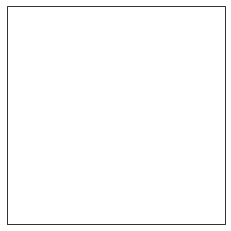

In [ ]:
def plot_heatmap(storm_center_lat, storm_center_lon):
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
    width = 20
    height = 20
    ax.set_extent([storm_center_lon - width / 2, 
                   storm_center_lon + width / 2, 
                   storm_center_lat - height / 2, 
                   storm_center_lat + height / 2], ccrs.Geodetic())
    print(storm_center_lon)
    ax.coastlines()
    plt.show()


plot_heatmap(storm_center_lat, storm_center_lon)

In [ ]:
import iris
import matplotlib.pyplot as plt

import cartopy.crs as ccrs


# load some sample iris data
fname = iris.sample_data_path('rotated_pole.nc')
temperature = iris.load_cube(fname)

# iris comes complete with a method to put bounds on a simple point
# coordinate. This is very useful...
temperature.coord('grid_latitude').guess_bounds()
temperature.coord('grid_longitude').guess_bounds()

# turn the iris Cube data structure into numpy arrays
gridlons = temperature.coord('grid_longitude').contiguous_bounds()
gridlats = temperature.coord('grid_latitude').contiguous_bounds()
temperature = temperature.data

# set up a map
ax = plt.axes(projection=ccrs.PlateCarree())

# define the coordinate system that the grid lons and grid lats are on
rotated_pole = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
plt.pcolormesh(gridlons, gridlats, temperature, transform=rotated_pole)

ax.coastlines()

plt.show()

KeyboardInterrupt: 

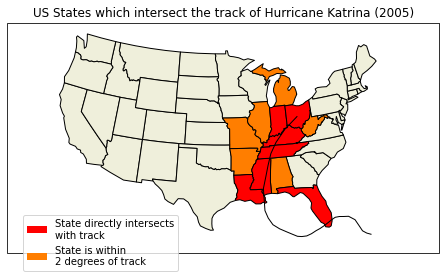

In [ ]:
"""
Hurricane Katrina
-----------------
This example uses the power of Shapely to illustrate states that are likely to
have been significantly impacted by Hurricane Katrina.
"""
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import shapely.geometry as sgeom

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader


def sample_data():
    """
    Return a list of latitudes and a list of longitudes (lons, lats)
    for Hurricane Katrina (2005).
    The data was originally sourced from the HURDAT2 dataset from AOML/NOAA:
    https://www.aoml.noaa.gov/hrd/hurdat/newhurdat-all.html on 14th Dec 2012.
    """
    lons = [-75.1, -75.7, -76.2, -76.5, -76.9, -77.7, -78.4, -79.0,
            -79.6, -80.1, -80.3, -81.3, -82.0, -82.6, -83.3, -84.0,
            -84.7, -85.3, -85.9, -86.7, -87.7, -88.6, -89.2, -89.6,
            -89.6, -89.6, -89.6, -89.6, -89.1, -88.6, -88.0, -87.0,
            -85.3, -82.9]

    lats = [23.1, 23.4, 23.8, 24.5, 25.4, 26.0, 26.1, 26.2, 26.2, 26.0,
            25.9, 25.4, 25.1, 24.9, 24.6, 24.4, 24.4, 24.5, 24.8, 25.2,
            25.7, 26.3, 27.2, 28.2, 29.3, 29.5, 30.2, 31.1, 32.6, 34.1,
            35.6, 37.0, 38.6, 40.1]

    return lons, lats


def main():
    fig = plt.figure()
    # to get the effect of having just the states without a map "background"
    # turn off the background patch and axes frame
    ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
    ax.patch.set_visible(False)

    ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

    shapename = 'admin_1_states_provinces_lakes'
    states_shp = shpreader.natural_earth(resolution='110m',
                                         category='cultural', name=shapename)

    lons, lats = sample_data()

    ax.set_title('US States which intersect the track of '
                 'Hurricane Katrina (2005)')

    # turn the lons and lats into a shapely LineString
    track = sgeom.LineString(zip(lons, lats))

    # buffer the linestring by two degrees (note: this is a non-physical
    # distance)
    track_buffer = track.buffer(2)

    def colorize_state(geometry):
        facecolor = (0.9375, 0.9375, 0.859375)
        if geometry.intersects(track):
            facecolor = 'red'
        elif geometry.intersects(track_buffer):
            facecolor = '#FF7E00'
        return {'facecolor': facecolor, 'edgecolor': 'black'}

    ax.add_geometries(
        shpreader.Reader(states_shp).geometries(),
        ccrs.PlateCarree(),
        styler=colorize_state)

    ax.add_geometries([track_buffer], ccrs.PlateCarree(),
                      facecolor='#C8A2C8', alpha=0.0)
    ax.add_geometries([track], ccrs.PlateCarree(),
                      facecolor='none', edgecolor='k')

    # make two proxy artists to add to a legend
    direct_hit = mpatches.Rectangle((0, 0), 1, 1, facecolor="red")
    within_2_deg = mpatches.Rectangle((0, 0), 1, 1, facecolor="#FF7E00")
    labels = ['State directly intersects\nwith track',
              'State is within \n2 degrees of track']
    ax.legend([direct_hit, within_2_deg], labels,
              loc='lower left', bbox_to_anchor=(0.025, -0.1), fancybox=True)

    plt.show()


if __name__ == '__main__':
    main()